In [ ]:
## install lime into scvelo_jupyterlab
micromamba activate scvelo_jupyter
micromamba run -n scvelo_jupyter pip install lime
micromamba run -n scvelo_jupyter pip install torch torchvision torchaudio

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import lime
import sklearn
import sklearn.ensemble
import sklearn.metrics

## Fetching data, training a classifier

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 75 points : 4


In [21]:
import scipy as sp
import pandas as pd
import os
loadpath="/Users/sfurlan/Library/CloudStorage/OneDrive-FredHutchinsonCancerCenter/computation/Analysis/viewmastR/pbmc"

In [22]:
Xtrain = sp.io.mmread(os.path.join(loadpath, "scrna/train.mm.gz"))

In [23]:
Xtest = sp.io.mmread(os.path.join(loadpath, "scrna/test.mm.gz"))

In [24]:
Ytrain = pd.read_csv(os.path.join(loadpath, "scrna/train_labels.tsv.gz"), compression = "gzip")
Ytest = pd.read_csv(os.path.join(loadpath, "scrna/test_labels.tsv.gz"), compression = "gzip")
Ytrain = Ytrain['train'].to_numpy()
Ytest = Ytest['test'].to_numpy()


In [25]:


from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.001)
nb.fit(Xtrain, Ytrain)

MultinomialNB(alpha=0.001)

In [26]:
pred = nb.predict(Xtest)
sklearn.metrics.f1_score(Ytest, pred, average='weighted')

0.9359517749320161

In [27]:
import scanpy as sc
import anndata as ad
import matplotlib as plt
samples = {
    "query": os.path.join(loadpath, "scrna/query/3file"),
}
adatas = {}
for sample_id, filename in samples.items():
    sample_adata = sc.read_10x_mtx(filename)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)
pca = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/pca_reduction.tsv.gz"), sep='\t', compression="gzip")
umap = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/umap_reduction.tsv.gz"), sep='\t', compression="gzip")
adata.obsm['X_umap'] = umap.iloc[:,[1,2]].to_numpy()
adata.obsm['X_pca'] = pca.iloc[:,1:51].to_numpy()
meta = pd.read_csv(os.path.join(loadpath, "scrna/query/3file/meta.csv"), sep=',')
df2 = adata.obs
meta.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
adata.obs = pd.concat([meta, df2], axis=1)


/Users/sfurlan/micromamba/envs/scvelo_jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


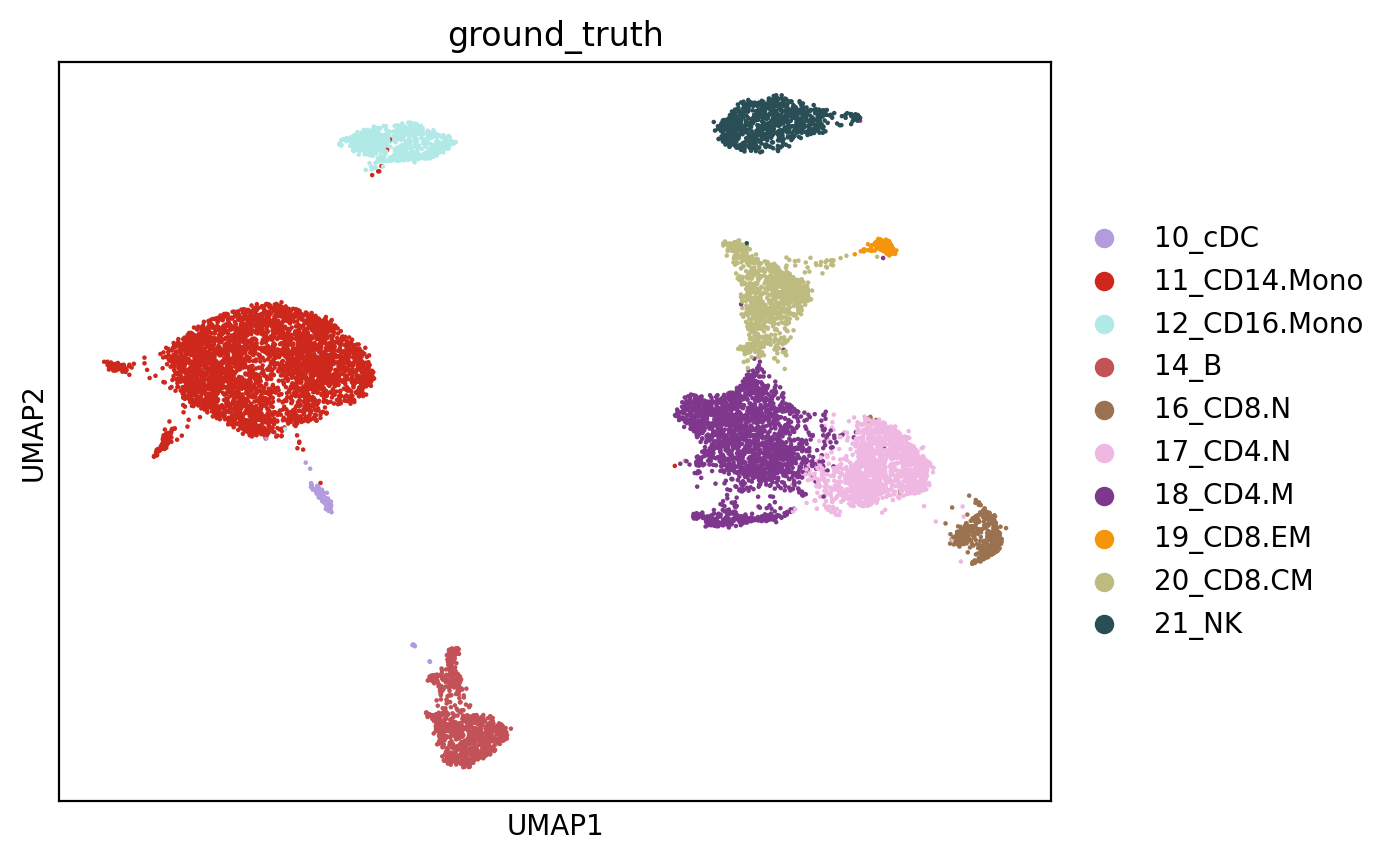

In [28]:
colors = pd.read_csv(os.path.join(loadpath, "scrna/colors.tsv.gz"), sep=',', compression="gzip")
#print(zip(colors.labels.to_numpy(), colors.colors.to_numpy()))
cmap = dict(zip(colors.labels.to_numpy(), colors.colors.to_numpy()))
#plt.colors.ListedColormap(colors.colors, name=colors.labels)
sc.pl.umap(adata, color = "ground_truth", palette = cmap)

In [15]:
query = sp.io.mmread(os.path.join(loadpath, "scrna/query.mm.gz"))
labels = pd.read_csv(os.path.join(loadpath, "scrna/labels.tsv.gz"), sep='\t', compression="gzip")
adata.obs["nb_pred"] = labels.to_numpy()[nb.predict(query)-1]



/Users/sfurlan/micromamba/envs/scvelo_jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


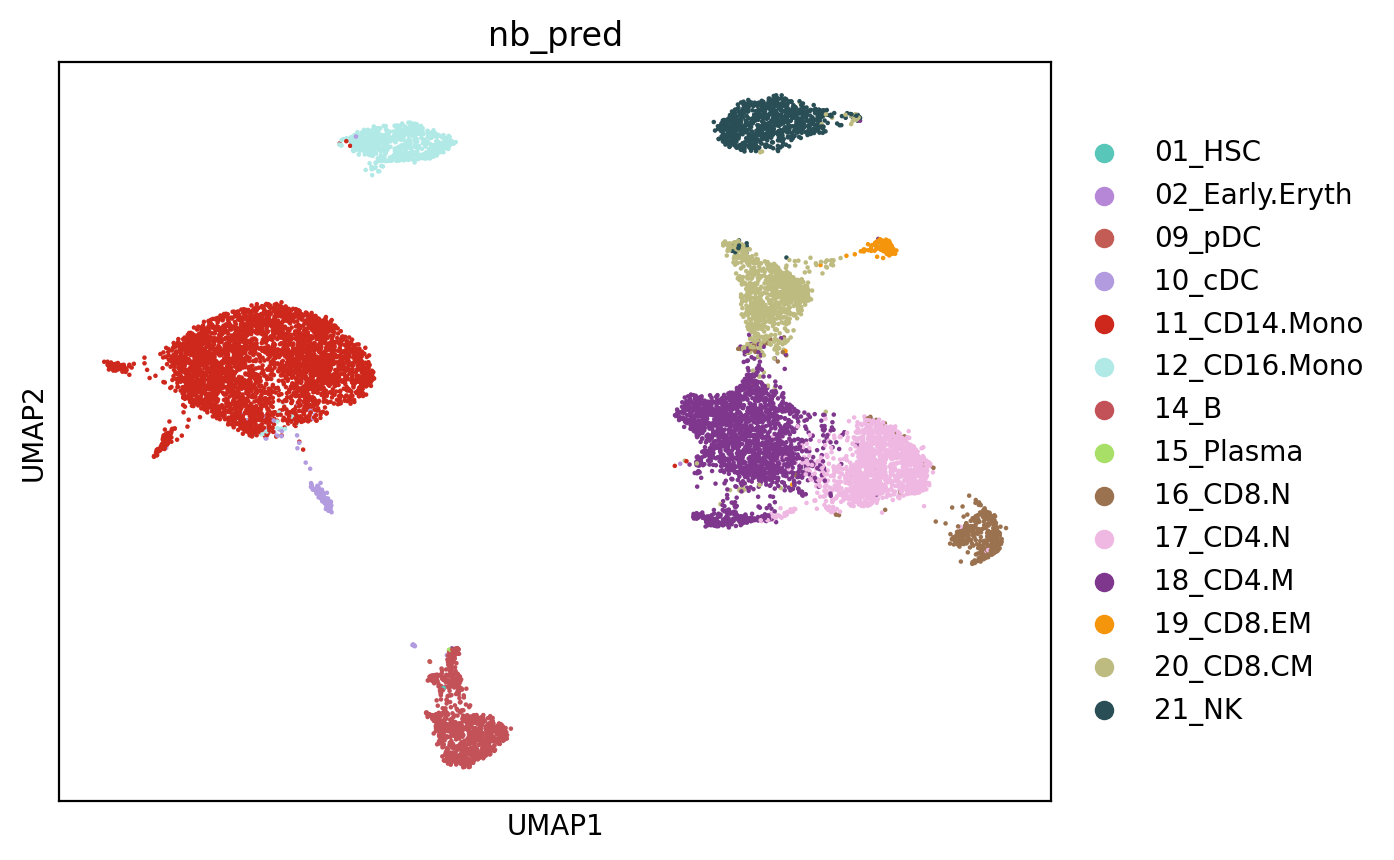

In [16]:

sklearn.metrics.f1_score( adata.obs['ground_truth'], adata.obs['nb_pred'], average='weighted')
sc.pl.umap(adata, color = "nb_pred", palette = cmap)


/var/folders/1m/j4y5ttpx03v9hsmkwjqz2cfh0000gp/T/ipykernel_99789/3776142018.py:7: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Axes: >

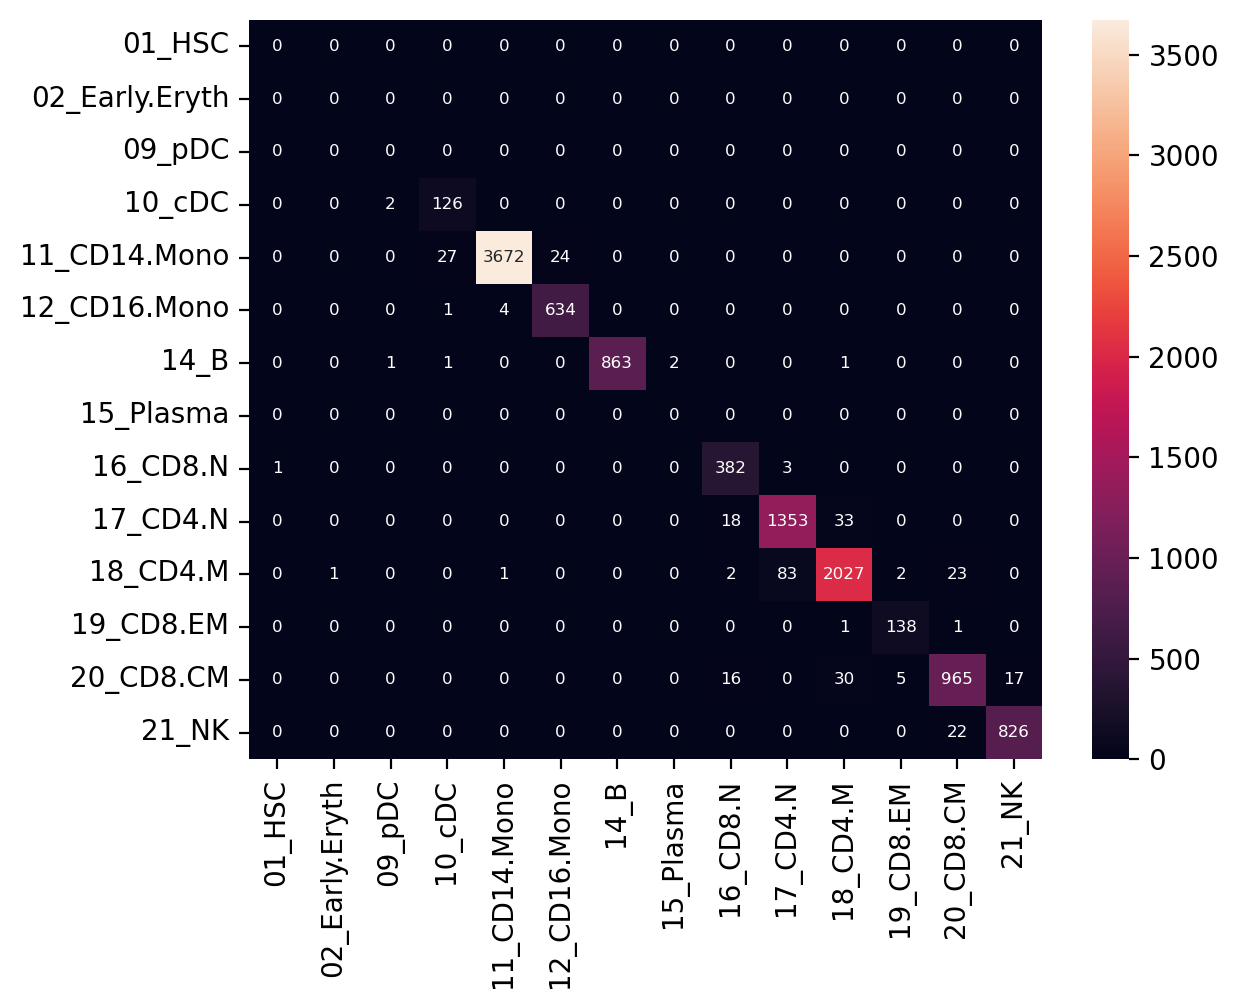

In [17]:
from sklearn import metrics
import numpy as np
import seaborn as sns
import matplotlib as plt
labs = pd.concat([adata.obs['ground_truth'], adata.obs['nb_pred']], axis = 0 ).drop_duplicates().sort_values().to_numpy()
cm = metrics.confusion_matrix(adata.obs['ground_truth'], adata.obs['nb_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs, annot_kws={"size": 6})

/Users/sfurlan/micromamba/envs/scvelo_jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


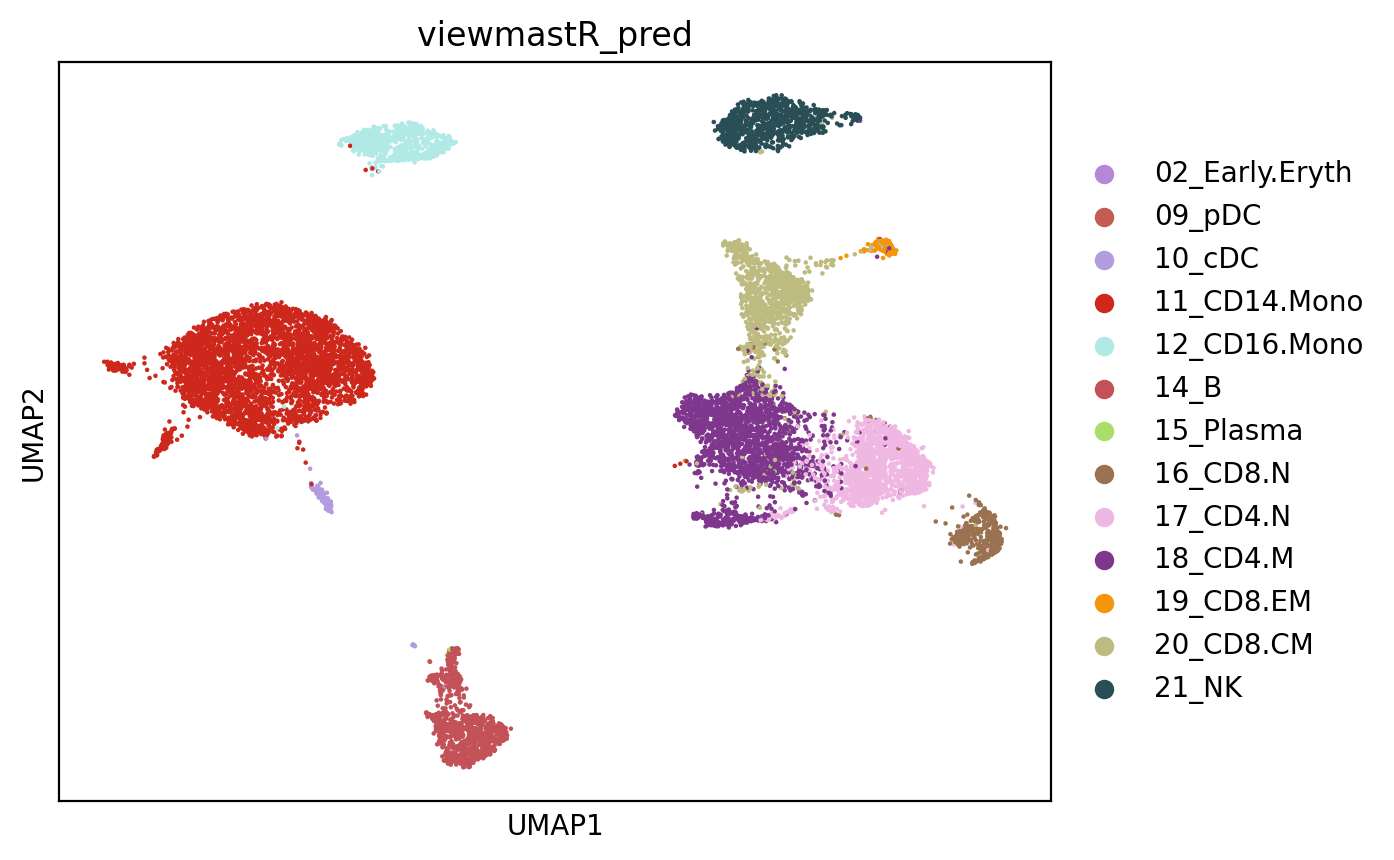

In [18]:
adata.obs.columns
sc.pl.umap(adata, color = "viewmastR_pred", palette = cmap)

/var/folders/1m/j4y5ttpx03v9hsmkwjqz2cfh0000gp/T/ipykernel_99789/2993452041.py:2: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Axes: >

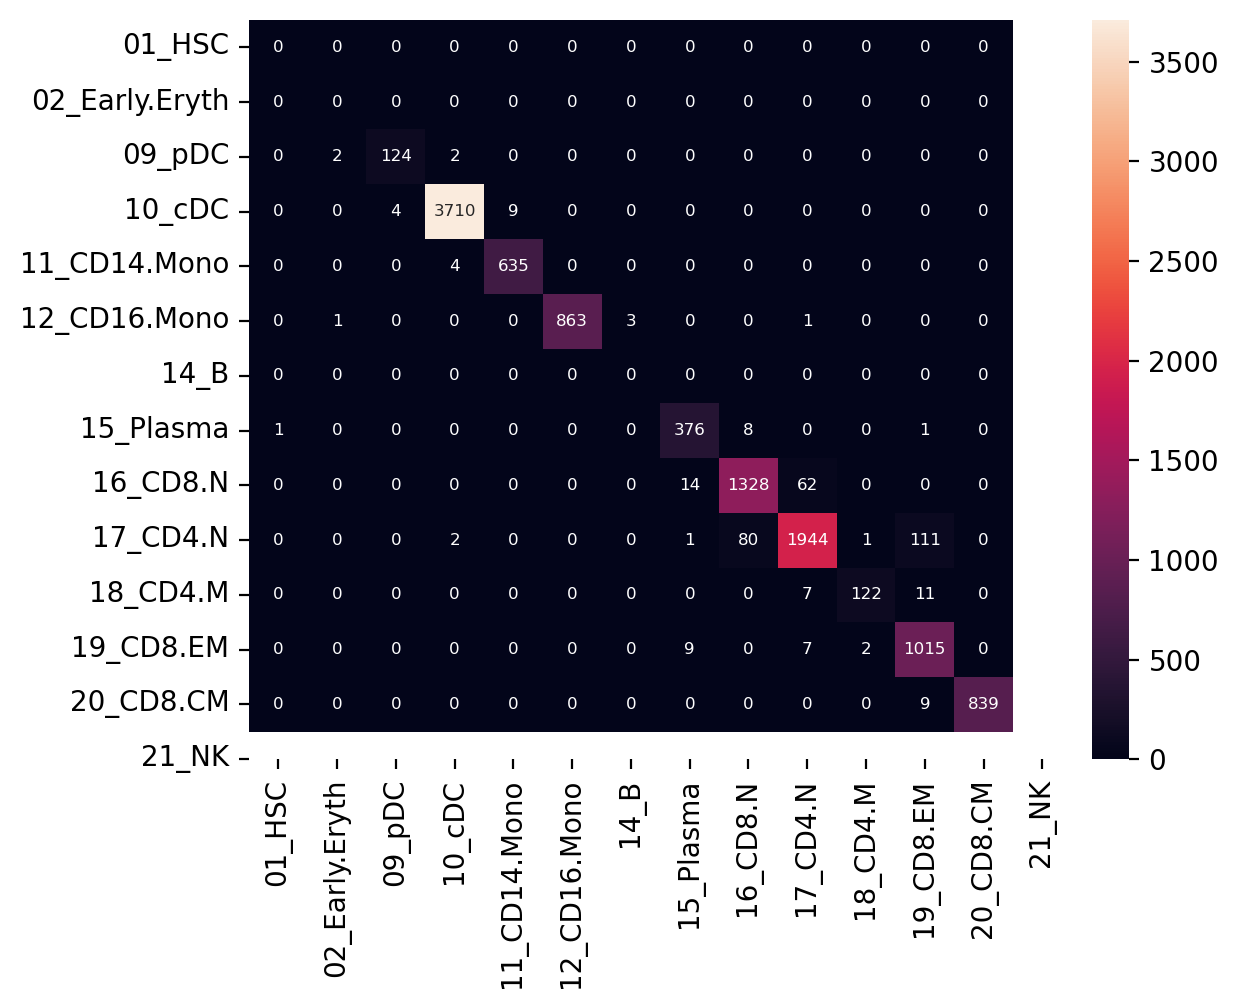

In [19]:
cm = metrics.confusion_matrix(adata.obs['ground_truth'], adata.obs['viewmastR_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs, annot_kws={"size": 6})

## Neural Networks

In [81]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5, 
                    hidden_layer_sizes=(2000, 300), random_state=1)

clf.fit(np.asarray(Xtrain.todense()), Ytrain)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(2000, 300), random_state=1)

/Users/sfurlan/micromamba/envs/scvelo_jupyter/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


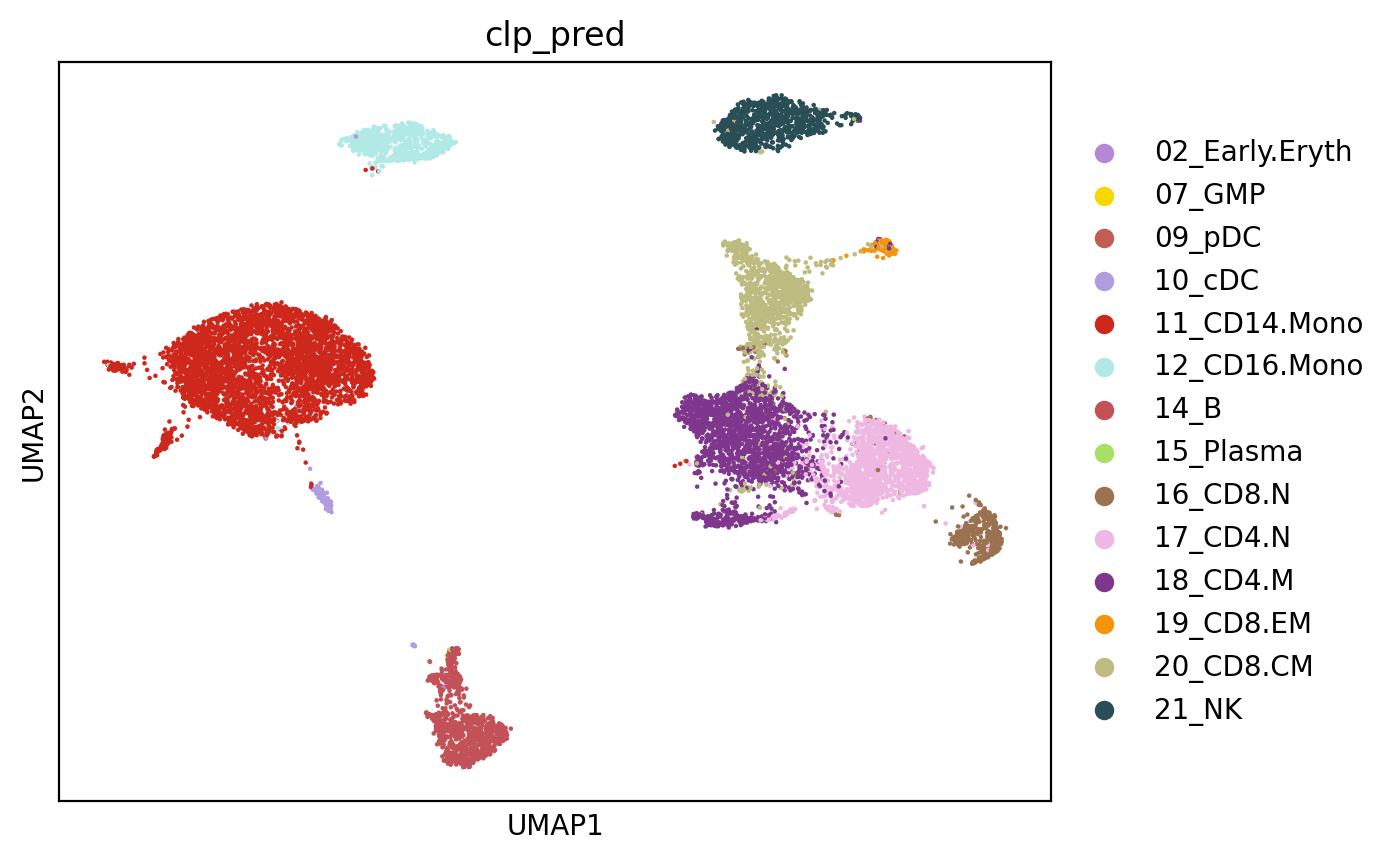

In [86]:
adata.obs["clp_pred"] = labels.to_numpy()[clf.predict(np.asarray(query.todense()))-1]
sc.pl.umap(adata, color = "clp_pred", palette = cmap)

/var/folders/1m/j4y5ttpx03v9hsmkwjqz2cfh0000gp/T/ipykernel_90294/3214377019.py:2: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


<Axes: >

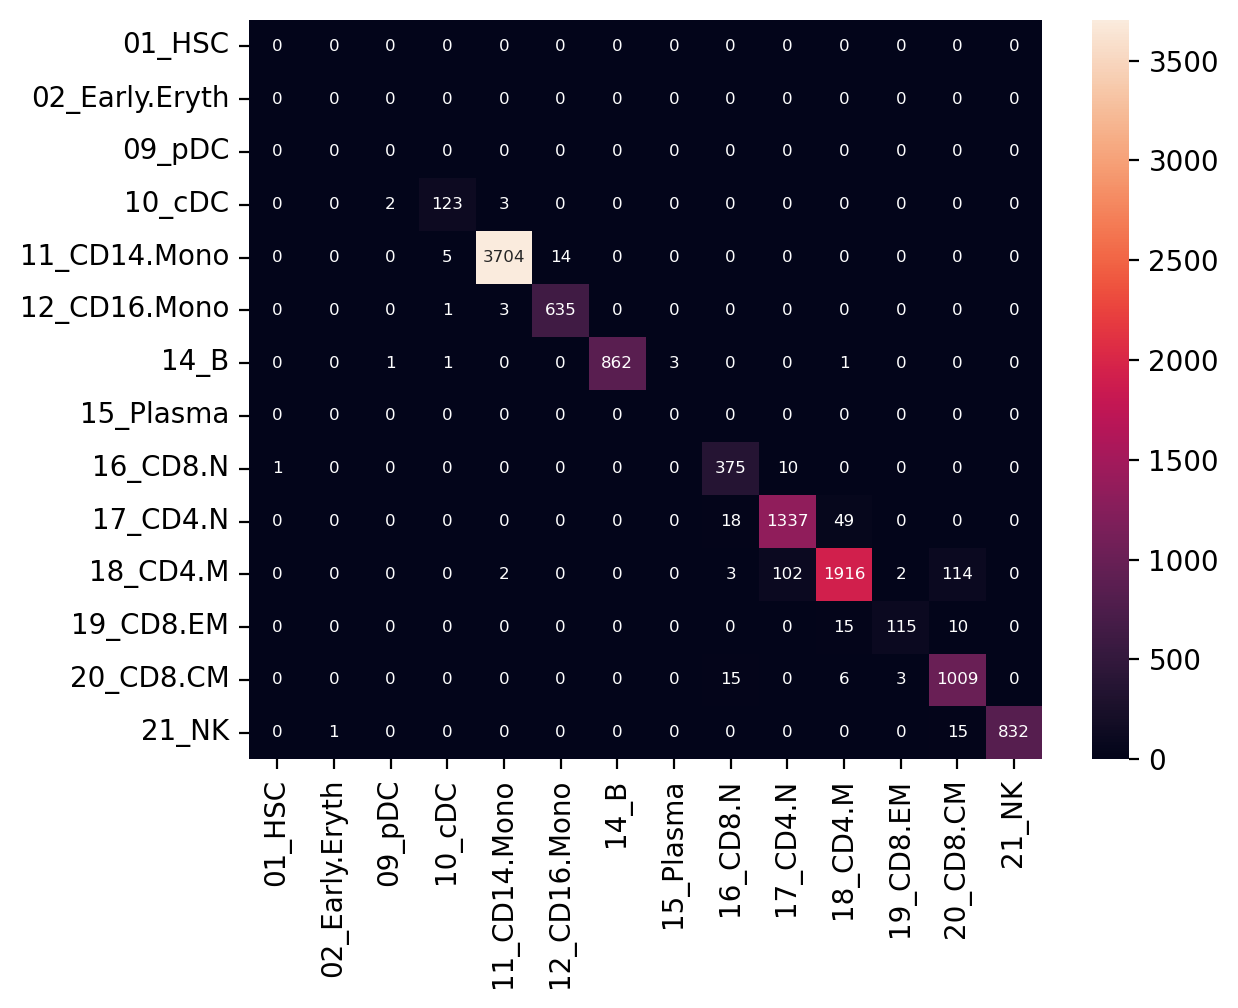

In [87]:
cm = metrics.confusion_matrix(adata.obs['ground_truth'], adata.obs['clp_pred'])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=labs, yticklabels=labs, annot_kws={"size": 6})

## TorchTensorflow

In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Explaining predictions using lime

In [135]:
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, nb)

In [136]:
print(c.predict_proba([newsgroups_test.data[0]]).round(3))

ValueError: X has 155448 features, but MultinomialNB is expecting 6396 features as input.

In [ ]:
newsgroups_train.data[idx]

'\nArcher> How about "Interactive Sex with Madonna"?\n\nor "Sexium" for short.\n\n/Lars'

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

Previously, we used the default parameter for label when generating explanation, which works well in the binary case.  
For the multiclass case, we have to determine for which labels we will get explanations, via the 'labels' parameter.  
Below, we generate explanations for labels 0 and 17.

In [ ]:
idx = 1340
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6, labels=[0, 17])
print('Document id: %d' % idx)
print('Predicted class =', class_names[nb.predict(test_vectors[idx]).reshape(1, -1)[0, 0]])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 1340
Predicted class = atheism
True class: atheism


Now, we can see the explanations for different labels. Notice that the positive and negative signs are with respect to a particular label - so that words that are negative towards class 0 may be positive towards class 15, and vice versa.

In [ ]:
print('Explanation for class %s' % class_names[0])
print('\n'.join(map(str, exp.as_list(label=0))))
print()
print('Explanation for class %s' % class_names[17])
print('\n'.join(map(str, exp.as_list(label=17))))

Explanation for class atheism
(np.str_('Caused'), 0.261906710651669)
(np.str_('Rice'), 0.14190711268284603)
(np.str_('Genocide'), 0.12922846812448716)
(np.str_('owlnet'), -0.08934676745583581)
(np.str_('scri'), -0.08864373883681177)
(np.str_('certainty'), -0.08280371790623064)

Explanation for class mideast
(np.str_('fsu'), -0.0548972672355167)
(np.str_('Luther'), -0.052079509707438125)
(np.str_('Theism'), -0.05166096626029141)
(np.str_('Caused'), -0.03602494164766279)
(np.str_('jews'), 0.035293538596174685)
(np.str_('PBS'), 0.029949238218567414)


Another alternative is to ask LIME to generate labels for the top K classes. This is shown below with K=2.  
To see which labels have explanations, use the ````available_labels```` function.

In [ ]:
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[np.int64(0), np.int64(15)]


Now let's see some the visualization of the explanations. Notice that for each class, the words on the right side on the line are positive, and the words on the left side are negative. Thus, 'Caused' is positive for atheism, but negative for christian.

In [ ]:
exp.show_in_notebook(text=False)

We notice that the classifier is using reasonable words (such as 'Genocide', 'Luther', 'Semitic', etc), as well as unreasonable ones ('Rice', 'owlnet'). Let's zoom in and just look at the explanations for class 'Atheism'.

In [ ]:
exp.show_in_notebook(text=newsgroups_test.data[idx], labels=(0,))

Looking at this example demonstrates that there can be useful signal in the header or quotes that would generalize - i.e., the Subject line. There is also signal that would not generalize (e.g. email addresses and institution names).

## Explaining predictions without headers, quotes and footers

Finally, we follow the [suggestion of removing headers, footers and quotes](http://scikit-learn.org/stable/datasets/#filtering-text-for-more-realistic-training), and explain the same example with the new data.

In [17]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)
nb = MultinomialNB(alpha=.01)
nb.fit(train_vectors, newsgroups_train.target)
c = make_pipeline(vectorizer, nb)
explainer = LimeTextExplainer(class_names=class_names)

In [18]:
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[np.int64(15), np.int64(17)]


Notice how different the explanations are for the classifier without headers, footers and quotes. The prediction changes, but so do the reasons.

In [19]:
exp.show_in_notebook(text=False)

Let's see the explanation with the text for the top class (christian):

In [20]:
exp.show_in_notebook(text=newsgroups_test.data[idx], labels=(15,))

Notice how short the text became after removing all of that information. One begins to wonder if this version of the dataset is still useful, or if it is better to find another dataset altogether. Could a reasonable classifier detect that this document belongs to the class atheism?

Anyway, I hope this illustrated how to use LIME to explain arbitrary classifiers in the multiclass case!